In [1]:
import librosa 
import numpy as np
import matplotlib.pyplot as plt

In [2]:

signal,sr = librosa.load('./main_noised_int.wav',sr=16000, mono=False)
noise,sr = librosa.load('./speaker_noise.wav',sr=16000, mono=False)

m=5
ref =2

In [3]:
signal_stft = librosa.stft(signal, n_fft=1024, hop_length=512)
noise_stft = librosa.stft(noise, n_fft=1024, hop_length=512)

In [4]:
import scipy

rtf_vecs = []
faulty = 0

for f in range(signal_stft.shape[1]):
        cov_sig = np.cov(signal_stft[:,f] )
        cov_noise = np.cov(noise_stft[:,f] )
        eigenvalues, eigenvectors = np.linalg.eig(cov_sig @ np.linalg.inv(cov_noise) )
        dominant_eigenvector = eigenvectors[:,np.argmax(eigenvalues)]
        dominant_eigenvector / np.abs(dominant_eigenvector[ref])
        rtf_vecs.append(dominant_eigenvector)

print(faulty)
rtf_vecs = np.vstack(rtf_vecs)

0


In [5]:
C, F, T = signal_stft.shape  # (channels, freq_bins, time)

ws = []


for f in range(F):
    
    cov_sig = signal_stft[:,f] @ np.conj(signal_stft[:,f]).T
    inv_cov =  np.linalg.inv(cov_sig + np.eye(m) * 1e-6)
    numerator = inv_cov @ rtf_vecs[f]
    denom = np.conj(rtf_vecs[f]).T @ inv_cov @ rtf_vecs[f]
    w = numerator / denom
    ws.append(w)
ws = np.vstack(ws)

In [6]:
 beamformed = np.einsum('ab,bac->ac', np.conj(ws), signal_stft)


In [7]:
beamformed_sig = librosa.istft(beamformed, hop_length=512, n_fft=1024)

In [8]:
from IPython.display import Audio

In [9]:
Audio(beamformed_sig, rate=16000)

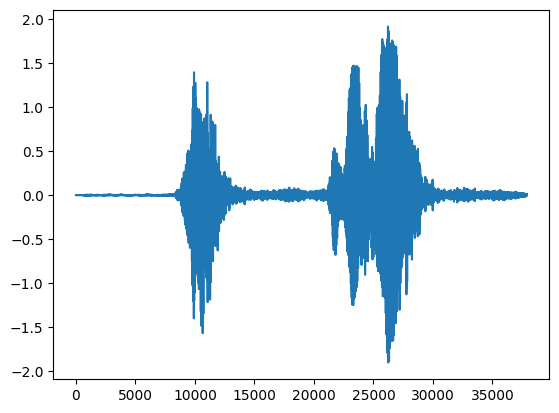

In [10]:
plt.plot(beamformed_sig)